In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
import lightgbm
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv")

In [ ]:
train.head()

# EDA 

**Findings**

1. There are no missing values both in train and test sets.
2. Besides f_27, the rest of the features are numerical (float64 and int64).
3. Target variable is binary. In the training set, the target variable 0 and 1 have similar instances.
4. Train and test set has 16 continuous features. The distributions of each are very similar (standard probability distribution). Besides that, there are 14 categorical features that were labeled encoded. Their distributions also are pretty similar. 
5. Especially a couple of Shapley feature interaction values ([link](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap)) are important for the future outcome. I plotted them below. This idea is not mine, therefore I have to cite the notebook that I saw first, so you can give credit to the person who deserves it ([link](https://www.kaggle.com/code/ambrosm/tpsmay22-gradient-boosting-quickstart)). The second interaction plots are mine. I added couple more interactions to the dataset to boost performance even more. It didn't change the results that much.  

In [ ]:
train.drop("id", inplace = True, axis = 1)
test.drop("id", inplace = True, axis = 1)

train.name = "Train"
test.name = "Test"

In [ ]:
# define categorical and continuos features

cont_features = []
for col in train.columns:
    if train[col].dtype != "object":
        if (train[col].nunique() > 20) & (col != "id"):
            cont_features.append(col)

cat_features = []
for col in train.columns:
    if (train[col].dtype != "object") & (col != "target"):
            if train[col].nunique() < 20:
                cat_features.append(col)

In [ ]:
#kde plot for train and test set

fig,ax = plt.subplots(nrows = 4,ncols = 4,figsize = (16,9))
row_no = 0
col_no = 0
for col in cont_features:
    sns.kdeplot(train[col], ax = ax[row_no][col_no], fill = True, color = "#c78036")
    sns.kdeplot(test[col], ax = ax[row_no][col_no], fill = True,color = "#cc0000")
    if (col_no+1) % 4 == 0:
        row_no += 1
        col_no = 0
    else:
        col_no += 1
        
plt.tight_layout()
plt.show()

In [ ]:
# plot categorical features
        
fig,ax = plt.subplots(nrows = 2,ncols = 14, figsize = (20,8))
row_no = 0
col_no = 0
for col in cat_features:
    sns.countplot(x = train[col], ax = ax[row_no][col_no], color = "#c78036")
    sns.countplot(x = test[col], ax = ax[row_no+1][col_no], color = "#cc0000")
    ax[row_no][col_no].set_ylabel("")
    ax[row_no+1][col_no].set_ylabel("")
    ax[row_no][col_no].set_yticks([])
    ax[row_no+1][col_no].set_yticks([])
    ax[row_no][col_no].set_xticks([])
    ax[row_no+1][col_no].set_xticks([])
    col_no += 1
        
plt.tight_layout()
plt.show()

In [ ]:
# analyze the target variable
sns.countplot(x = train["target"])
plt.title("Target Variable Counts")
plt.ylabel("")
plt.xlabel("")
plt.show()

print(train["target"].value_counts())

In [ ]:
# Feature interactions 
fig, axes = plt.subplots(ncols = 4, figsize = (16,9))
sns.scatterplot(x = train["f_22"],y = train["f_05"], hue = train["target"],ax = axes[0])
sns.scatterplot(x = train["f_02"],y = train["f_21"], hue = train["target"],ax = axes[1])
sns.scatterplot(x = train["f_00"],y = train["f_26"], hue = train["target"],ax = axes[2])
sns.scatterplot(x = train["f_01"],y = train["f_26"], hue = train["target"],ax = axes[3])
plt.tight_layout()
plt.show()

In [ ]:
# more interactions
train_f30_2 = train.loc[train["f_30"] == 2]
train_f30_1 = train.loc[train["f_30"] == 1]

fig,axes = plt.subplots(ncols = 2,figsize = (10,5))
sns.scatterplot(x = train_f30_2["f_30"],y = train_f30_2["f_26"], hue = train["target"],ax = axes[0])
axes[0].axhline(y = 3.5, linestyle = "--", color = "red",alpha = 0.2)
axes[0].axhline(y = -1, linestyle = "--", color = "red",alpha = 0.2)
sns.scatterplot(x = train_f30_1["f_30"],y = train_f30_1["f_26"], hue = train["target"],ax = axes[1])
axes[1].axhline(y = 3, linestyle = "--", color = "red",alpha = 0.2)
plt.tight_layout()
plt.show()

In [ ]:
# more interactions

fig,axes = plt.subplots(ncols = 2,figsize = (10,5))
sns.scatterplot(x = train_f30_2["f_30"],y = train_f30_2["f_25"], hue = train["target"],ax = axes[0])
axes[0].axhline(y = 2.5, linestyle = "--", color = "red",alpha = 0.2)
axes[0].axhline(y = -1.5, linestyle = "--", color = "red",alpha = 0.2)
sns.scatterplot(x = train_f30_1["f_30"],y = train_f30_1["f_25"], hue = train["target"],ax = axes[1])
axes[1].axhline(y = 3, linestyle = "--", color = "red",alpha = 0.2)
axes[1].axhline(y = -4, linestyle = "--", color = "red",alpha = 0.2)
plt.tight_layout()
plt.show()

# Preprocessing and Models

**Preprocessing Steps and Strategies Used to improve Model Performances:**

1. **Memory reduction:** For faster computing, I defined a memory reducing function. By doing that I saved 78% of the default memory both in the training and test set.

Since the dataset is large, 

* I started with faster ml models. Since the distributions are Gaussian, LogisticRegression is suitable. Another fast ml model that came to my mind is LightGBM. The baseline performances were 0.615 and 0.82 respectively. The difference was serious. Therefore I continued with LGBM. While using LGBM, using the evaluation set makes computing time a lot longer therefore turned codes into comments and put the results below each trial.

* The need for cross-validation decreases. Therefore to save computing energy, I used basic train_test_split. In my first trial, to make sure that my assumption is true, I simulated models at 5 different seeds. Deviation in performance was negligible. (I held that code in the notebook so that you can verify the results.) 

2. **Adding sample statistics for continuous features:** Increased LGBM performance a little.

3. **Counting number of occurrences in feature f_27:** Increased LGBM performance a little.

4. **Counting unique characters in feature f_27:** Increased LGBM performance a little.

5. **Adding feature interactions:** 3 features. They were selected according to the Shapley values computed [here.](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap) Increased LGBM performance considerably.

In [ ]:
# Defined Functions 

def get_dataset():
    train = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv")
    test = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv")
    train.drop("id", inplace = True, axis = 1)
    test.drop("id", inplace = True, axis = 1)
    train.name = "Train"
    test.name = "Test"
    train = memory_reducer(train)
    test = memory_reducer(test)
   
    
    return train,test

# Adding sample statistics

def sample_statistics(data):
    data["cont_sum"] = data[cont_features].sum(axis = 1)
    data["cont_mean"] = data[cont_features].mean(axis = 1)
    data["cont_std"] = data[cont_features].std(axis = 1)
    return data

# adding unique characters
# original function @
# https://www.kaggle.com/code/kellibelcher/tps-may-2022-eda-lgbm-neural-networks

def add_unique_chars(data,cat_col):
    data_copy = data.copy()
    data["unique_chars"] = data[cat_col].apply(lambda x: len(set(x)))
    data_copy.drop("f_27", axis = 1, inplace = True)
    return data_copy

def count_characters(data):
    data_copy = data.copy()
    for char in string.ascii_uppercase:
        data_copy[f"f_27{char}"] = data_copy["f_27"].str.count(char)
    return data_copy

# plot evaluation

def plot_lgb(model):
    plt.figure()
    plt.plot(model.evals_result_["training"]["auc"], label = "Training AUC")
    plt.plot(model.evals_result_["valid_1"]["auc"], label = "Validation AUC")
    plt.legend()
    plt.title("AUC Scores by Epoch")
    plt.show()
# convenient function

def run_lgb(data,plot = False, plot_importance = False):
    X = data.drop("target", axis = 1)
    y = data["target"]
    
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    model = LGBMClassifier(metric = "auc", objective = "binary",n_estimators=5000, min_child_samples=80)
    model.fit(X_train,y_train, eval_set = [(X_train,y_train),(X_test,y_test)], callbacks = [lightgbm.early_stopping(50),lightgbm.log_evaluation(period = 0)])
    pred = model.predict(X_test)
    score_lgb = roc_auc_score(y_test,pred)
    print(f"LGBM Accuracy: {score_lgb:.3f}")
    if plot:
        plot_lgb(model)
    if plot_importance:
        fig,axes = plt.subplots(ncols = 2,figsize = (10,5))
        lightgbm.plot_importance(model,importance_type = "gain",ax = axes[0],title = "Feature Importance Based on Info Gain")
        lightgbm.plot_importance(model,importance_type = "split",ax = axes[1],title = "Feature Importance Based on # of Usage")
        plt.tight_layout()
        plt.show()

# feature interactions
# label 1,0 and -1 accurding to the interactions
# label1 for instances that have high probability to belong class 1
# label0 for instances that is placed in middle regions (see scatterplot)
# label-1 for instances that have high probability to belong class 0
# original function is @ https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras

def calculate_feat_int(df):
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    return df

# more interactions

def my_interactions(df):
    
    helper_list = np.zeros(len(df))
    for idx,row in df.iterrows():
        if (row["f_30"] == 2) & (row["f_26"] < -1):
            helper_list[idx] = -1
        elif (row["f_30"] == 2) & (-1 < row["f_26"] < 3.5):
            helper_list[idx] = 0
        else:
            helper_list[idx] = 1

    df["my_interaction"] = helper_list.astype(np.int8)
    
    helper_list = np.zeros(len(df))
    for idx,row in df.iterrows():
        if (row["f_30"] == 2) & ((row["f_25"] < -1.5) | (row["f_25"] > 2.6)):
            helper_list[idx] = 1
        elif (row["f_30"] == 2) & (-1 < row["f_25"] < 2.6):
            helper_list[idx] = 0
        else: #irrelevent ones
            helper_list[idx] = -1
    df["my_interaction_2"] = helper_list.astype(np.int8)
    return df
# Memory reduction

def memory_reducer(data):
    
    before = data.memory_usage().sum()
    print(f"Memory usage: {before / 1024**2:.3f} MB")
    for col in data.columns:
        
        if data[col].dtype != "object":
            
           
            if (data[col].dtype == "int64") and (np.abs(data[col]).max() < 127):
                data[col] = data[col].astype("int8")

            elif (data[col].dtype == "int64") and (np.abs(data[col]).max() < 32767):
                data[col] = data[col].astype("int16")

            elif (data[col].dtype == "int64") and (np.abs(data[col]).max() < 2147483647):
                data[col] = data[col].astype("int16")

            elif (data[col].dtype == "float64") and (np.abs(data[col]).max() < np.finfo(np.float16).max):
                data[col] = data[col].astype("float16")

            elif (data[col].dtype == "float64") and (np.abs(data[col]).max() < np.finfo(np.float32).max):
                data[col] = data[col].astype("float32")

            else:
                continue
        
        else:
            continue
    
    after = data.memory_usage().sum() 
    print(f"{data.name} data memory usage after preprocessing: {after / 1024**2:.3f} MB ({(before-after)/before *100:.2f}% reduction)")
    return data

In [ ]:
# test the model performances at 5 different seeds...

#SEEDS = np.random.randint(0,100,size = 5)
#scores_lgbm = []
#scores_log = []

#for SEED in SEEDS:
    
#    train_numeric = train.drop("f_27",axis = 1)
#    X_train,X_test,y_train,y_test = train_test_split(train_numeric.iloc[:,:-1],train_numeric.iloc[:,-1], random_state = SEED)
#    model = LGBMClassifier()
#    model.fit(X_train,y_train)
#    pred = model.predict(X_test)
#    score = accuracy_score(y_test,pred)
#    scores_lgbm.append(score)
    
#    model2 = LogisticRegression(solver = "liblinear", max_iter = 500)
#    model2.fit(X_train,y_train)
#    pred = model2.predict(X_test)
#    score = accuracy_score(y_test,pred)
#    scores_log.append(score)
    
#print(f"LGBM Accuracy: {np.mean(scores_lgbm):.3f} ({np.std(scores_lgbm):.3f})")
#print(f"Logistic Regression Accuracy: {np.mean(scores_log):.3f} ({np.std(scores_log):.3f})")

In [ ]:
# Baseline Performance 

#train,test = get_dataset()
#train_copy = train.copy()
#train_numeric = train_copy.drop("f_27",axis = 1)
#X_train,X_test,y_train,y_test = train_test_split(train_numeric.iloc[:,:-1],train_numeric.iloc[:,-1])
#model = LGBMClassifier()
#model.fit(X_train,y_train)
#pred = model.predict(X_test)
#score_lgb = roc_auc_score(y_test,pred)

#model2 = LogisticRegression(solver = "liblinear", max_iter = 500)
#model2.fit(X_train,y_train)
#pred = model2.predict(X_test)
#score_log = roc_auc_score(y_test,pred)


#print(f"LGBM ROC AUC Score: {score_lgb:.3f}")
#print(f"Logistic Regression ROC AUC Score: {score_log:.3f} ")

# LGBM ROC AUC Score: 0.819 - Logistic Regression ROC AUC Score: 0.614 

In [ ]:
# add sample statistics

#train_copy = train.copy()
#train_add = sample_statistics(train_copy)
#train_add.drop("f_27",axis = 1, inplace = True)
#run_lgb(train_add)

# training's auc: 0.964011 - valid_1's auc: 0.937057 - LGBM Accuracy: 0.878

In [ ]:
# add sample statistics
# add unique variables

#train_copy = train.copy()
#train_unique = add_unique_chars(train_copy, cat_features)
#train_unique = sample_statistics(train_unique)
#run_lgb(train_unique)

In [ ]:
# add sample statistics
# add unique variables

#train_copy = train.copy()
#train_unique = add_unique_chars(train_copy, cat_features)
#train_unique = sample_statistics(train_unique)
#run_lgb(train_unique,plot=True, plot_importance=1)

# training's auc: 0.964715 - valid_1's auc: 0.937251 - LGBM Accuracy: 0.878

In [ ]:
# add unique variables
# count letters
# # add sample statistics

#train_copy = train.copy()
#train_copy = count_characters(train_copy)
#train_copy = add_unique_chars(train_copy, cat_features)
#train_copy = sample_statistics(train_copy)
#run_lgb(train_copy)

# training's auc: 0.993648 - valid_1's auc: 0.972252 - LGBM Accuracy: 0.917

In [ ]:
# add unique variables
# count letters
# add sample statistics
# considering feature interactions

#train_copy = train.copy()
#train_copy = count_characters(train_copy)
#train_copy = add_unique_chars(train_copy, cat_features)
#train_copy = sample_statistics(train_copy)
#train_copy = calculate_feat_int(train_copy)
#run_lgb(train_copy)

# training's auc: 0.997319 valid_1's auc: 0.984467 - LGBM Accuracy: 0.937

In [ ]:
# add unique variables
# count letters
# add sample statistics
# considering more feature interactions

#train_copy = train.copy()
#train_copy = count_characters(train_copy)
#train_copy = add_unique_chars(train_copy, cat_features)
#train_copy = sample_statistics(train_copy)
#train_copy = calculate_feat_int(train_copy)
#train_copy = my_interactions(train_copy)
#run_lgb(train_copy,plot=True, plot_importance=1)

# training's auc: 0.996888 - valid_1's auc: 0.984629 - LGBM Accuracy: 0.937

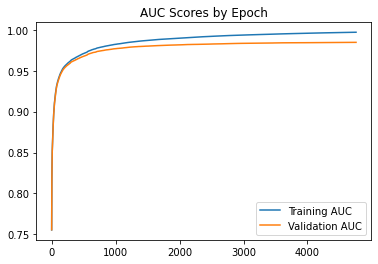

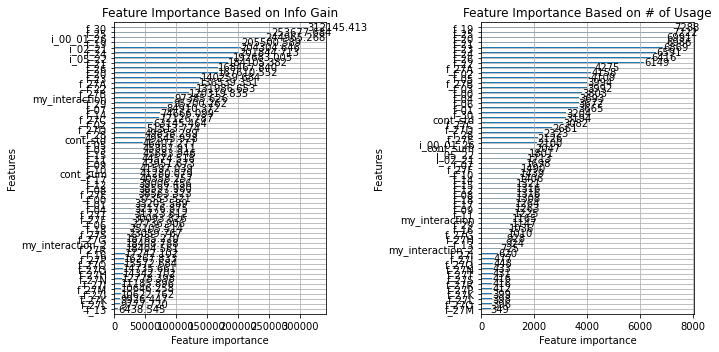